# Node2Vec embedding for link prediction

1. loading the data with edge_index, train_mask, test_mask

2. using Node2vec in torch_geometric to retrieve the emedding for each node
https://colab.research.google.com/github/AntonioLonga/PytorchGeometricTutorial/blob/main/Tutorial12/Tutorial12%20Node2Vec%20for%20label%20prediction.ipynb

3. produce edge embedding

4. Linke prediction classifiers using LogisticRegressionCV
https://stellargraph.readthedocs.io/en/stable/demos/link-prediction/node2vec-link-prediction.html

Grover, A., & Leskovec, J. (2016, August). node2vec: Scalable feature learning for networks. In Proceedings of the 22nd ACM SIGKDD international conference on Knowledge discovery and data mining (pp. 855-864).

In [34]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)


2.0.0+cu118


In [35]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
# !pip install -q torch-cluster -f https://data.pyg.org/whl/torch-torch-1.10.0+cu113.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [36]:
# import library
from torch_geometric.nn import Node2Vec
import torch_geometric.utils
import os.path as osp
import torch
from torch_geometric.datasets import Planetoid
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [37]:
dataset = 'Cora'
path = osp.join('.', 'data', dataset)
# dowload or load the Cora dataset
dataset = Planetoid(path, dataset)  
data = dataset[0]

# check if cuda is available to send the model and tensors to the GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [38]:
print(data)
print(data.edge_index)
print(data.train_mask)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])
tensor([ True,  True,  True,  ..., False, False, False])


In [39]:
print(device)

cpu


## Generate the Node2Vec embeddings

In [40]:
model = Node2Vec(data.edge_index, embedding_dim=128, walk_length=20,
                 context_size=10, walks_per_node=10,
                 num_negative_samples=1, p=1, q=1, sparse=True).to(device)

loader = model.loader(batch_size=128, shuffle=True, num_workers=2)  # data loader to speed the train 
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)  # initzialize the optimizer 

In [41]:
def train():
    model.train() # put model in the train model
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad() # set the gradient to zero
        loss = model.loss(pos_rw.to(device), neg_rw.to(device)) # compute the loss for the batch
        loss.backward()
        optimizer.step() # optimize the parameters
        total_loss += loss.item()
    return total_loss / len(loader)


@torch.no_grad()
def test():
    model.eval()
    z = model()
    acc = model.test(z[data.train_mask], data.y[data.train_mask],
                     z[data.test_mask], data.y[data.test_mask],
                     max_iter=10)
    return acc


for epoch in range(1, 101):
    loss = train()
    #acc = test()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')

Epoch: 10, Loss: 1.7414
Epoch: 20, Loss: 0.9723
Epoch: 30, Loss: 0.8709
Epoch: 40, Loss: 0.8445
Epoch: 50, Loss: 0.8348
Epoch: 60, Loss: 0.8299
Epoch: 70, Loss: 0.8270
Epoch: 80, Loss: 0.8260
Epoch: 90, Loss: 0.8259
Epoch: 100, Loss: 0.8246


In [45]:
# save all the node embedding after training
z = model()

## visualize node embedding

In [46]:
# from tensor to numpy
emb_128 = z.detach().cpu().numpy()

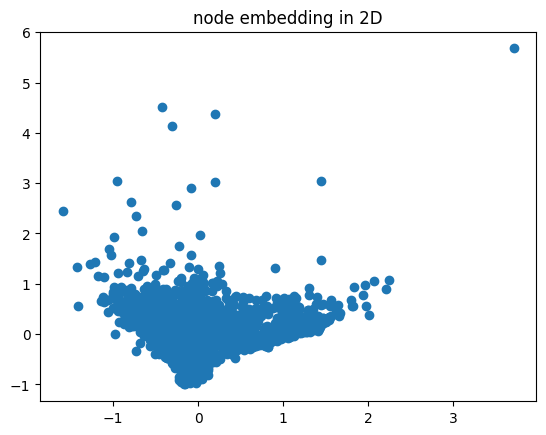

In [47]:
from sklearn.decomposition import PCA
# fit and transform using PCA
pca = PCA(n_components=2)
emb2d = pca.fit_transform(emb_128)


plt.title("node embedding in 2D")
plt.scatter(emb2d[:,0],emb2d[:,1])
plt.show()

# generating X_train/X_test/y_train/y_test with negative sampling

In [50]:
torch.manual_seed(42)
train_p, test_p = 0.7, 0.3
# Step 1: Find a random permutation order of the links using torch.randperm
# Step 2: Assign the first 70% (rounded down) of the links as the training set (X_train), and the remaining 30% as the test (X_test). 
# Step 3: Create new variables y_train, y_test storing all ones vector corresponding to the number of links in the corresponding set.
#         Make sure to put them on the memory of the `device` (default will be cpu but we want everything to be on GPU). 

# 1. find a random permutation order of the links using torch.randperm
num_edge = data.edge_index.shape[1]
perm_index = torch.randperm(num_edge)

# 2 the first 70% of the links as the training set size and the remain 30% as the testing set
import math
train_size = math.floor(num_edge * train_p)
test_size = num_edge - train_size

# store the first 70% edge as train, the remain 30% is test
X_pos_train = data.edge_index[:, perm_index[:train_size]]
X_pos_test = data.edge_index[:, perm_index[train_size:]]

# 3. create all-ones vector correspoinding to the number of links in the corresponding set
y_pos_train = torch.ones(train_size, device=device)
y_pos_test = torch.ones(test_size, device=device)


#########################################

In [51]:
print(X_pos_train.shape, y_pos_train.shape)
print(X_pos_test.shape, y_pos_test.shape)
print(X_pos_train)

torch.Size([2, 7389]) torch.Size([7389])
torch.Size([2, 3167]) torch.Size([3167])
tensor([[2109, 1914, 1871,  ..., 2080, 1742, 1498],
        [1085, 1464,  228,  ...,  487, 2444, 2025]])


## sampling negative links

In [52]:
import random
torch.manual_seed(42)
random.seed(42)
negative_sampling_rate = 1

# Step 1: Use torch_geometric.utils.negative_sampling to obtain `negative_sampling_rate` number of negative samples for each positive link in `data.edge_index`.
#         Carefully read the documentation and check which arguments you would need to pass and how. 
# Step 2: Append the first 60% (roudned down) of the non-existing links to the training set (data.train_mask), next 10% (rounded down) to the validation (data.val_mask), 
#         and the remaining to the test (data.test_mask). Use torch.cat with the correct dimension.
# Step 3: Append an all zeros vector to data.train_y, data.val_y, data.test_y corresponding to the number of links newly added to the corresponding set.
#         Make sure to match the `device` of the tensor. Use torch.cat with the correct dimension.
## write your code below [0.6 points] ## 

# 1. Use torch_geometric.utils.negative_sampling to obtain `negative_sampling_rate` number of negative samples for each positive link in `data.edge_index`
num_nodes = data.num_nodes
num_edge = data.edge_index.shape[1]
neg_edge_index = torch_geometric.utils.negative_sampling(edge_index=data.edge_index, num_nodes=num_nodes, num_neg_samples=negative_sampling_rate*num_edge)


# 2. append the first 70% of the non-existing links to the training set
num_neg_edge = neg_edge_index.shape[1]
neg_train_size = math.floor(num_neg_edge * train_p)
neg_test_size = num_neg_edge - train_size

X_neg_train = neg_edge_index[:, :neg_train_size]
X_neg_test = neg_test_mask = neg_edge_index[:, neg_train_size:]

X_train = torch.cat((X_pos_train, X_neg_train), dim=-1)
X_test = torch.cat((X_pos_test, X_neg_test), dim=-1)

# 3. Append an all zeros vector to data.train_y, data.val_y, data.test_y corresponding to the number of links newly added to the corresponding set.
y_train = torch.cat((y_pos_train, torch.zeros(neg_train_size, device=device)), dim=-1)
y_test = torch.cat((y_pos_test, torch.zeros(neg_test_size, device=device)), dim=-1)

#########################################

In [53]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_train)

torch.Size([2, 14778]) torch.Size([14778])
torch.Size([2, 6334]) torch.Size([6334])
tensor([[2109, 1914, 1871,  ..., 1175, 1800,  312],
        [1085, 1464,  228,  ..., 2148, 1250,  551]])


## Compute edge embedding using the Node2Vec embedding

In [76]:
# compute edge embedding
# X_train
X_train_edge_emb = []
for u, v in X_train.t():
    X_train_edge_emb.append(np.abs([emb_128[u]-emb_128[v]]))
# to make the dimension of X_train from 3D to 2D
X_train_edge_emb = np.squeeze(np.array(X_train_edge_emb), axis=1)

# X_test
X_test_edge_emb = []
for u, v in X_test.t():
    X_test_edge_emb.append(np.abs([emb_128[u]-emb_128[v]]))
# to make the dimension of X_test from 3D to 2D
X_test_edge_emb = np.squeeze(np.array(X_test_edge_emb), axis=1)

# link prediction classifier: Logistirc Regression Classifier

Build a logistic regression CV

In [78]:
from sklearn.linear_model import LogisticRegressionCV
lr_clf = LogisticRegressionCV(Cs=10, cv=10, scoring="roc_auc", max_iter=2000)
lr_clf.fit(X_train_edge_emb, y_train)

LogisticRegressionCV(cv=10, max_iter=2000, scoring='roc_auc')

Evaluate the classifiers using prediction

In [89]:
from sklearn.metrics import roc_auc_score
y_preds = lr_clf.predict(X_test_edge_emb)
print(roc_auc_score(y_test, y_preds))

0.923744868961162
